<a href="https://colab.research.google.com/github/ykato27/LSTM/blob/main/LSTM_TFLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 必要なライブラリのインポート
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import tflearn

In [ ]:
dataframe = pd.read_csv('international-airline-passengers.csv', usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')

訓練データとテストデータに分けてあとで評価できるように分ける

In [ ]:
dataset -= np.min(np.abs(dataset))
dataset /= np.max(np.abs(dataset))

In [ ]:
def create_dataset(dataset, steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(dataset)-steps_of_history, steps_in_future):
        X.append(dataset[i:i+steps_of_history])
        Y.append(dataset[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, steps_of_history, 1])
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 1
steps_in_future = 1

X, Y = create_dataset(dataset, steps_of_history, steps_in_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.3)

TFLearnでLSTMネットワークを構築していこう。今回は回帰問題なので、activation関数は恒等関数にして二乗誤差を最小にするように学習させる。

In [ ]:
net = tflearn.input_data(shape=[None, steps_of_history, 1])
net = tflearn.lstm(net, n_units=6)
net = tflearn.fully_connected(net, 1, activation='linear')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
        loss='mean_square')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=0.1, batch_size=1, n_epoch=30)

Training Step: 2699  | total loss: 0.00226 | time: 0.627s
| Adam | epoch: 030 | loss: 0.00226 -- iter: 89/90
Training Step: 2700  | total loss: 0.00212 | time: 1.640s
| Adam | epoch: 030 | loss: 0.00212 | val_loss: 0.00127 -- iter: 90/90
--


TensorBoardで誤差を可視化する

In [ ]:
model = tflearn.DNN(net, tensorboard_verbose=0)

引数tensorboard_verboseの値を0~3にすることで可視化するログレベルを調節できる。

0. 誤差と正解率
1. 誤差と正解率と勾配
2. 誤差と正解率と勾配と重み
3. 誤差と正解率と重みと活性度とスパースさ

が可視化できる。verboseのレベルを上げるとより詳細を可視化できるが、学習速度が落ちる。

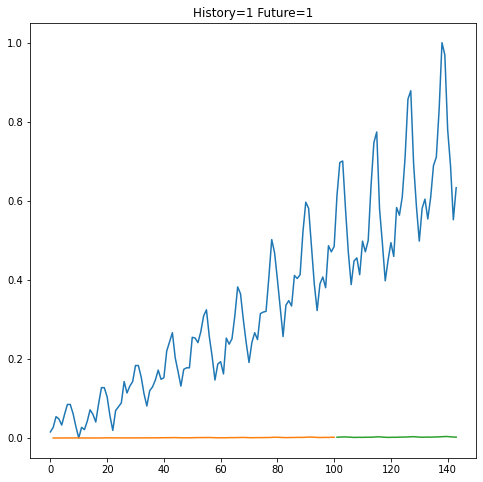

In [ ]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[steps_of_history:len(train_predict)+steps_of_history, :] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+steps_of_history:len(dataset), :] = test_predict

plt.figure(figsize=(8, 8))
plt.title('History={} Future={}'.format(steps_of_history, steps_in_future))
plt.plot(dataset)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)